# Two-Stage Equity Factor Timing Model

### Replicating: "Equity Factor Timing: A Two-Stage Machine Learning Approach"

---

## Overview

This notebook implements a two-stage machine learning framework for dynamic factor rotation:

**Stage 1:** Identify market risk regimes using K-Means clustering and stacking ensemble classification

**Stage 2:** Predict factor performance within each regime using Random Forest classifiers

### Key Features:
- Financial turbulence calculation (Kritzman & Li 2010)
- Market drawdown-based regime identification
- SMOTE for handling imbalanced classes
- Rolling window backtest with performance metrics
- Comprehensive visualizations and reporting

## 1. Import Libraries

In [1]:
'''
Core Libraries:
    pandas>=1.3.0
    numpy>=1.21.0
    scikit-learn>=1.0.0
    imbalanced-learn>=0.9.0
    matplotlib>=3.4.0
    seaborn>=0.11.0
    
For installing:
    use pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn
'''

# Import the complete implementation
from two_stage_factor_timing import *

# Additional imports for notebook
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded")

Libraries loaded


## 2. Load and Explore Data

In [2]:
# Load the 6-factor data
data_path = '6_factor.xls'
df = load_and_prepare_data(data_path)

# Display basic information
print(f"\nData Range: {df.index[0]} to {df.index[-1]}")
print(f"Total Observations: {len(df)} months")
print(f"\nColumns: {df.columns.tolist()}")
print("Number of NaN: " + str(df.isna().sum().sum()))

# Display first few rows
df.head()

Data loaded: 308 months from 2000-01-01 00:00:00 to 2025-08-01 00:00:00
Factors: ['Value', 'Growth', 'Momentum', 'Quality', 'Small_Cap', 'Low_Vol']

Data Range: 2000-01-01 00:00:00 to 2025-08-01 00:00:00
Total Observations: 308 months

Columns: ['Value', 'Growth', 'Momentum', 'Quality', 'Small_Cap', 'Low_Vol', 'RF']
Number of NaN: 0


,Value,Growth,Momentum,Quality,Small_Cap,Low_Vol,RF
Date,,,,,,,
2000-01-01,-1.12,1.3973,1.86,-6.15,4.21,-5.00,0.41
2000-02-01,-9.77,28.9531,18.02,-18.95,18.46,-5.71,0.43
2000-03-01,8.50,-13.7327,-6.85,11.65,-15.54,11.72,0.47
2000-04-01,6.45,-14.9815,-8.60,8.07,-4.75,3.85,0.46
2000-05-01,4.59,-7.3877,-8.99,4.05,-3.86,0.55,0.50


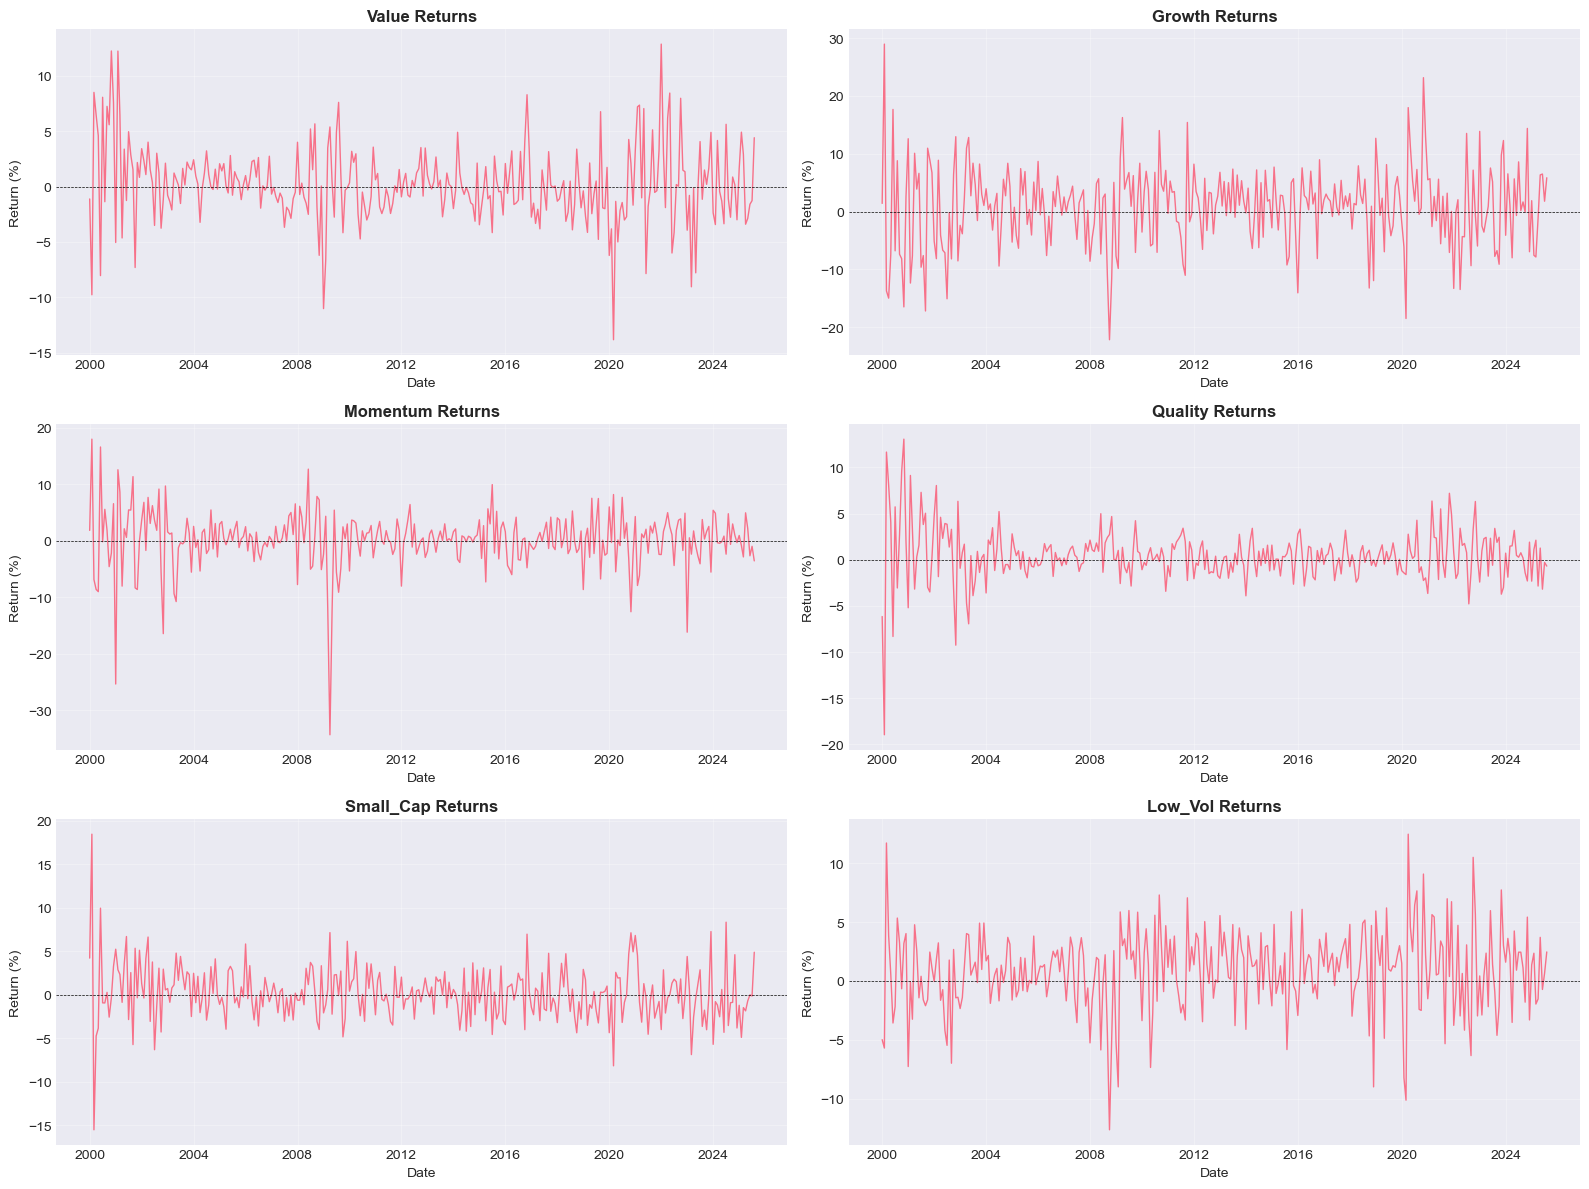

In [3]:
# Visualize factor returns over time
factor_cols = [col for col in df.columns if col != 'RF']

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.ravel()

for i, factor in enumerate(factor_cols):
    axes[i].plot(df.index, df[factor], linewidth=1)
    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    axes[i].set_title(f'{factor} Returns', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Return (%)')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Factor Statistics:
           mean   std    min    max  Sharpe
Value      0.19  3.45 -13.83  12.86    0.19
Growth     0.75  6.93 -22.18  28.95    0.37
Momentum   0.17  5.08 -34.34  18.02    0.11
Quality    0.42  2.87 -18.95  13.05    0.51
Small_Cap  0.17  3.13 -15.54  18.46    0.19
Low_Vol    0.86  3.46 -12.66  12.47    0.86


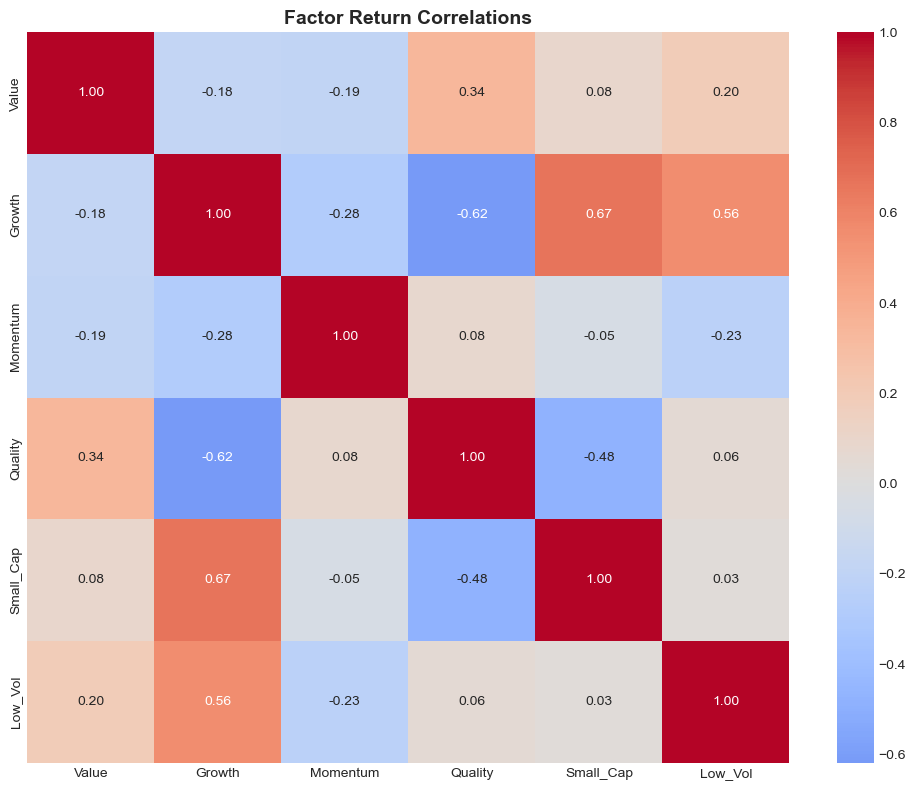

In [4]:
# Calculate and display factor statistics
factor_stats = df[factor_cols].describe().T
factor_stats['Sharpe'] = (factor_stats['mean'] * 12) / (factor_stats['std'] * np.sqrt(12))

print("\nFactor Statistics:")
print(factor_stats[['mean', 'std', 'min', 'max', 'Sharpe']].round(2))

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[factor_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Factor Return Correlations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 3. Feature Engineering

In [5]:
# Calculate market return as average of factors
df['Market_Return'] = df[factor_cols].mean(axis=1)

# Calculate rolling drawdown
print("Calculating market drawdown...")
df['Drawdown'] = calculate_market_drawdown(df['Market_Return'], window=3)

# Calculate financial turbulence
print("Calculating financial turbulence")
turbulence = construct_financial_turbulence(df, lookback=60)
df = df.join(turbulence)

# Remove NaN values
df = df.dropna()

print(f"\n Features engineered")
print(f"Final data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")

Calculating market drawdown...
Calculating financial turbulence

 Features engineered
Final data shape: (248, 10)
Date range: 2005-01-01 00:00:00 to 2025-08-01 00:00:00


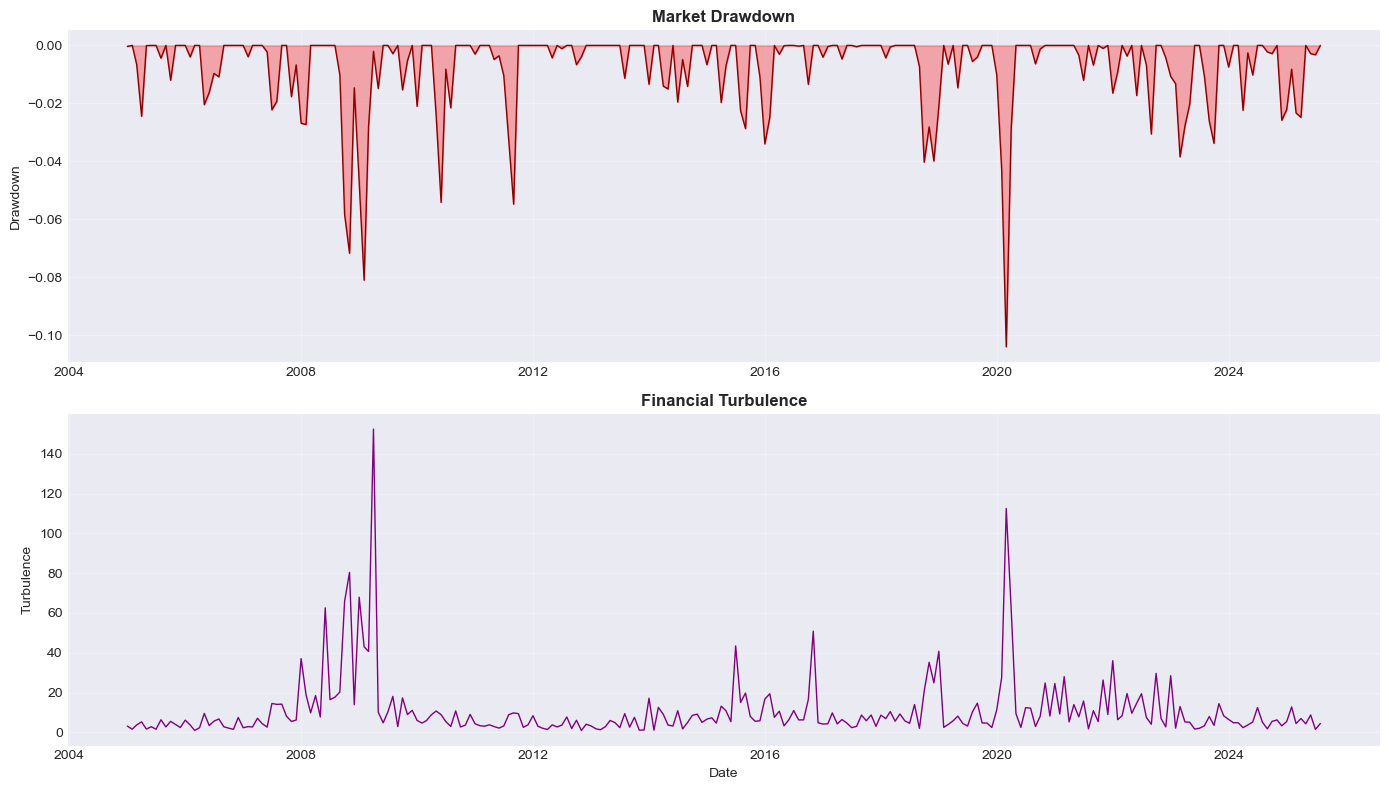

In [6]:
# Visualize drawdown and financial turbulence
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Drawdown plot
axes[0].fill_between(df.index, df['Drawdown'], 0, alpha=0.3, color='red')
axes[0].plot(df.index, df['Drawdown'], color='darkred', linewidth=1)
axes[0].set_title('Market Drawdown', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Drawdown')
axes[0].grid(True, alpha=0.3)

# Financial turbulence plot
axes[1].plot(df.index, df['Financial_Turbulence'], color='purple', linewidth=1)
axes[1].set_title('Financial Turbulence', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Turbulence')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Stage 1: Market Regime Identification

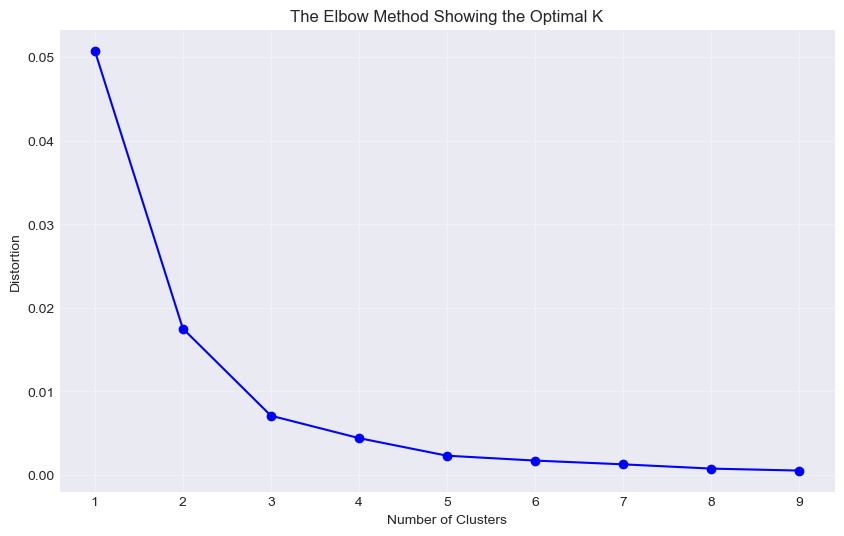

In [7]:
# Initialize regime classifier
regime_classifier = MarketRegimeClassifier(n_clusters=3)

# Find optimal number of clusters using elbow method
elbow_fig = regime_classifier.find_optimal_clusters(df['Drawdown'], max_k=9)
plt.show()


Market Regime Distribution:
Market_Regime
0    193
1     48
2      7
Name: count, dtype: int64

Regime Statistics:
  Regime 0 (Normal): Mean DD = -0.002, Count = 193 (77.8%)
  Regime 1 (Correction): Mean DD = -0.023, Count = 48 (19.4%)
  Regime 2 (Bear Market): Mean DD = -0.067, Count = 7 (2.8%)


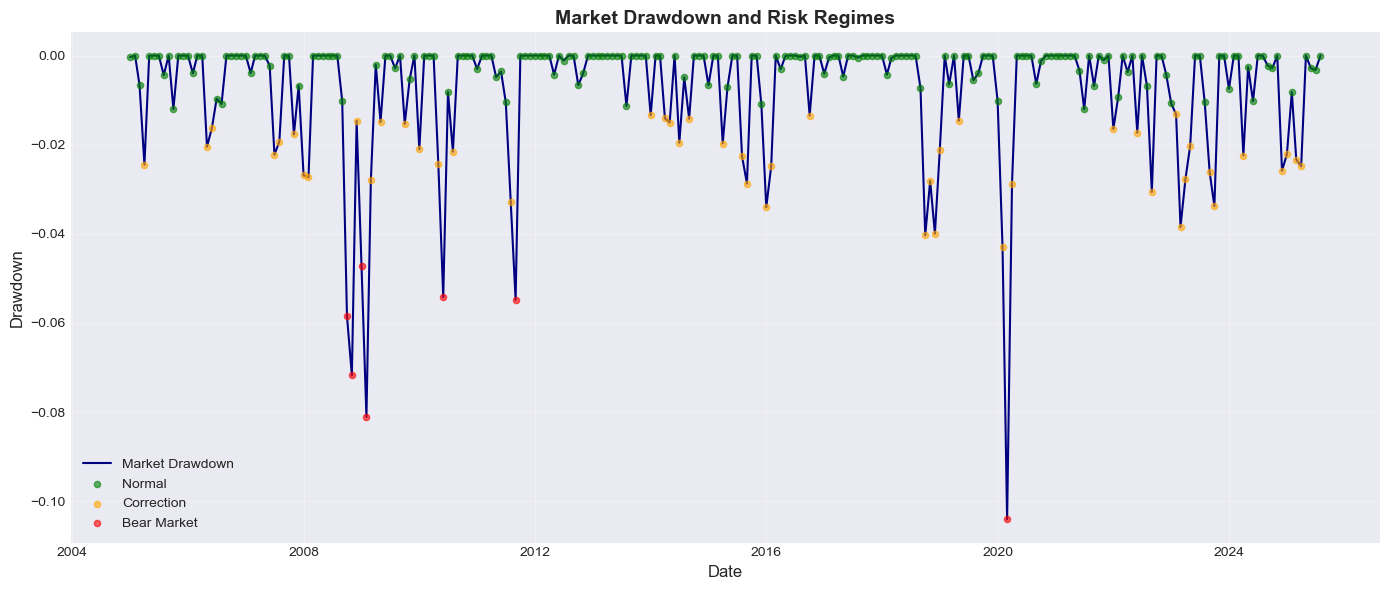

In [8]:
# Identify regimes using K-Means clustering
regimes = regime_classifier.identify_regimes_clustering(df['Drawdown'])
df['Regime'] = regimes

# Visualize regimes
regime_fig = plot_regime_identification(df['Drawdown'], regimes)
plt.show()

In [9]:
df.head()

,Value,Growth,Momentum,Quality,Small_Cap,Low_Vol,RF,Market_Return,Drawdown,Financial_Turbulence,Regime
Date,,,,,,,,,,,
2005-01-01,2.06,-5.2967,2.96,2.80,-1.11,-1.63,0.16,-0.036117,-0.000361,3.193979,0
2005-02-01,1.41,0.7420,3.43,1.32,-0.30,1.16,0.16,1.293667,0.000000,1.602766,0
2005-03-01,2.07,-4.1499,0.43,0.44,-1.41,-1.36,0.21,-0.663317,-0.006633,3.758141,0
2005-04-01,0.05,-6.3567,-0.68,0.97,-3.97,-0.80,0.21,-1.797783,-0.024492,5.290563,1
2005-05-01,-0.58,7.4179,0.37,-1.02,2.76,1.99,0.24,1.822983,-0.000076,1.677725,0


In [10]:
# Analyze regime characteristics
print("\nRegime Characteristics:")

for regime in sorted(df['Regime'].unique()):
    regime_data = df[df['Regime'] == regime]
    print(f"\nRegime {regime}:")
    print(f"  Occurrences: {len(regime_data)} months ({len(regime_data)/len(df)*100:.1f}%)")
    print(f"  Avg Drawdown: {regime_data['Drawdown'].mean():.4f}")
    print(f"  Avg Market Return: {regime_data['Market_Return'].mean():.2f}%")
    print(f"  Avg Turbulence: {regime_data['Financial_Turbulence'].mean():.2f}")
    
    # Best performing factor in this regime
    factor_means = regime_data[factor_cols].mean()
    best_factor = factor_means.idxmax()
    print(f"  Best avg factor: {best_factor} ({factor_means[best_factor]:.2f}%)")




Regime Characteristics:

Regime 0:
  Occurrences: 193 months (77.8%)
  Avg Drawdown: -0.0017
  Avg Market Return: 0.93%
  Avg Turbulence: 8.35
  Best avg factor: Growth (2.55%)

Regime 1:
  Occurrences: 48 months (19.4%)
  Avg Drawdown: -0.0234
  Avg Market Return: -1.27%
  Avg Turbulence: 14.57
  Best avg factor: Quality (0.70%)

Regime 2:
  Occurrences: 7 months (2.8%)
  Avg Drawdown: -0.0674
  Avg Market Return: -4.18%
  Avg Turbulence: 55.48
  Best avg factor: Momentum (2.89%)


In [11]:
# Train regime predictor (Stacking Ensemble)
print("Training regime classification model (Stacking Ensemble)\n")

regime_features = df[['Financial_Turbulence', 'Drawdown']]

regime_results = regime_classifier.train_regime_predictor(
    regime_features,
    regimes,
    use_smote=True
)


Training regime classification model (Stacking Ensemble)


After SMOTE - Class distribution:
  Regime 0: 193 samples
  Regime 1: 193 samples
  Regime 2: 193 samples

Stage 1 Model Performance:
  Cross-validation accuracy: 1.000 (+/- 0.000)
  Training accuracy: 1.000


## 5. Stage 2: Factor Performance Prediction

In [ ]:
# Initialize factor predictor
factor_predictor = FactorPerformancePredictor(factor_cols)

# Prepare features
factor_features = df[['Financial_Turbulence', 'Drawdown']]

# Train regime-specific models
print("Training factor performance predictors for each regime\n")
factor_results = factor_predictor.train_regime_specific_models(
    factor_features,
    df[factor_cols],
    df['Regime']
)

Training factor performance predictors for each regime


 Training models for Regime 0
Regime 0 data points: 193
  Value: Train Acc = 1.000, Pos/Neg = 23/170
  Growth: Train Acc = 0.943, Pos/Neg = 79/114
  Momentum: Train Acc = 0.984, Pos/Neg = 38/155
  Quality: Train Acc = 1.000, Pos/Neg = 7/186
  Small_Cap: Train Acc = 1.000, Pos/Neg = 12/181
  Low_Vol: Train Acc = 0.974, Pos/Neg = 34/159

 Training models for Regime 1
Regime 1 data points: 48
  Value: Train Acc = 1.000, Pos/Neg = 8/40
  Growth: Train Acc = 1.000, Pos/Neg = 7/41
  Momentum: Train Acc = 1.000, Pos/Neg = 9/39
  Quality: Train Acc = 1.000, Pos/Neg = 19/29
  Small_Cap: Train Acc = 1.000, Pos/Neg = 2/46
  Low_Vol: Train Acc = 1.000, Pos/Neg = 3/45

 Training models for Regime 2
Regime 2 data points: 7
  Value: No positive samples, skipping
  Growth: No positive samples, skipping
  Momentum: Train Acc = 1.000, Pos/Neg = 4/3
  Quality: Train Acc = 1.000, Pos/Neg = 3/4
  Small_Cap: No positive samples, skipping
  Low_Vol: No

In [13]:
# Analyze winning factor frequency by regime
print("\nFactor Performance by Regime:")


for regime in sorted(df['Regime'].unique()):
    regime_data = df[df['Regime'] == regime]
    
    # Find winning factor for each month
    winners = regime_data[factor_cols].idxmax(axis=1)
    winner_counts = winners.value_counts()
    
    print(f"\nRegime {regime} - Winning Factor Frequency:")
    for factor, count in winner_counts.items():
        pct = count / len(regime_data) * 100
        print(f"  {factor:15s}: {count:3d} months ({pct:5.1f}%)")


Factor Performance by Regime:

Regime 0 - Winning Factor Frequency:
  Growth         :  79 months ( 40.9%)
  Momentum       :  38 months ( 19.7%)
  Low_Vol        :  34 months ( 17.6%)
  Value          :  23 months ( 11.9%)
  Small_Cap      :  12 months (  6.2%)
  Quality        :   7 months (  3.6%)

Regime 1 - Winning Factor Frequency:
  Quality        :  19 months ( 39.6%)
  Momentum       :   9 months ( 18.8%)
  Value          :   8 months ( 16.7%)
  Growth         :   7 months ( 14.6%)
  Low_Vol        :   3 months (  6.2%)
  Small_Cap      :   2 months (  4.2%)

Regime 2 - Winning Factor Frequency:
  Momentum       :   4 months ( 57.1%)
  Quality        :   3 months ( 42.9%)


## 6. Backtesting Strategy

In [14]:
# Define train/test split (60/40)
train_size = int(len(df) * 0.6)

print("Backtest Configuration:")
print(f"Training period: {df.index[0]} to {df.index[train_size-1]}")
print(f"Testing period:  {df.index[train_size]} to {df.index[-1]}")
print(f"Training months: {train_size}")
print(f"Testing months:  {len(df) - train_size}")

# Initialize strategy
strategy = FactorTimingStrategy(regime_classifier, factor_predictor)

# Run backtest
backtest_results = strategy.backtest(
    df[factor_cols + ['RF']],
    factor_features,
    train_size
)


Backtest Configuration:
Training period: 2005-01-01 00:00:00 to 2017-04-01 00:00:00
Testing period:  2017-05-01 00:00:00 to 2025-08-01 00:00:00
Training months: 148
Testing months:  100

Backtesting from 2017-05-01 00:00:00 to 2025-08-01 00:00:00
Test period: 100 months


In [15]:
# Display performance metrics
metrics = backtest_results['metrics']

print("BACKTEST PERFORMANCE METRICS")

print(f"\nReturn Metrics:")
print(f"  Total Return:           {metrics['total_return']:>10.2f}%")
print(f"  Annualized Return:      {metrics['annualized_return']*100:>10.2f}%")
print(f"  Annualized Volatility:  {metrics['annualized_volatility']:>10.2f}%")
print(f"\nRisk-Adjusted Metrics:")
print(f"  Sharpe Ratio:           {metrics['sharpe_ratio']:>10.2f}")
print(f"  Maximum Drawdown:       {metrics['max_drawdown']*100:>10.2f}%")
print(f"  Win Rate:               {metrics['win_rate']*100:>10.2f}%")


BACKTEST PERFORMANCE METRICS

Return Metrics:
  Total Return:              3595.49%
  Annualized Return:           54.21%
  Annualized Volatility:        9.78%

Risk-Adjusted Metrics:
  Sharpe Ratio:                 4.56
  Maximum Drawdown:            -1.07%
  Win Rate:                    98.00%


## 7. Visualizations

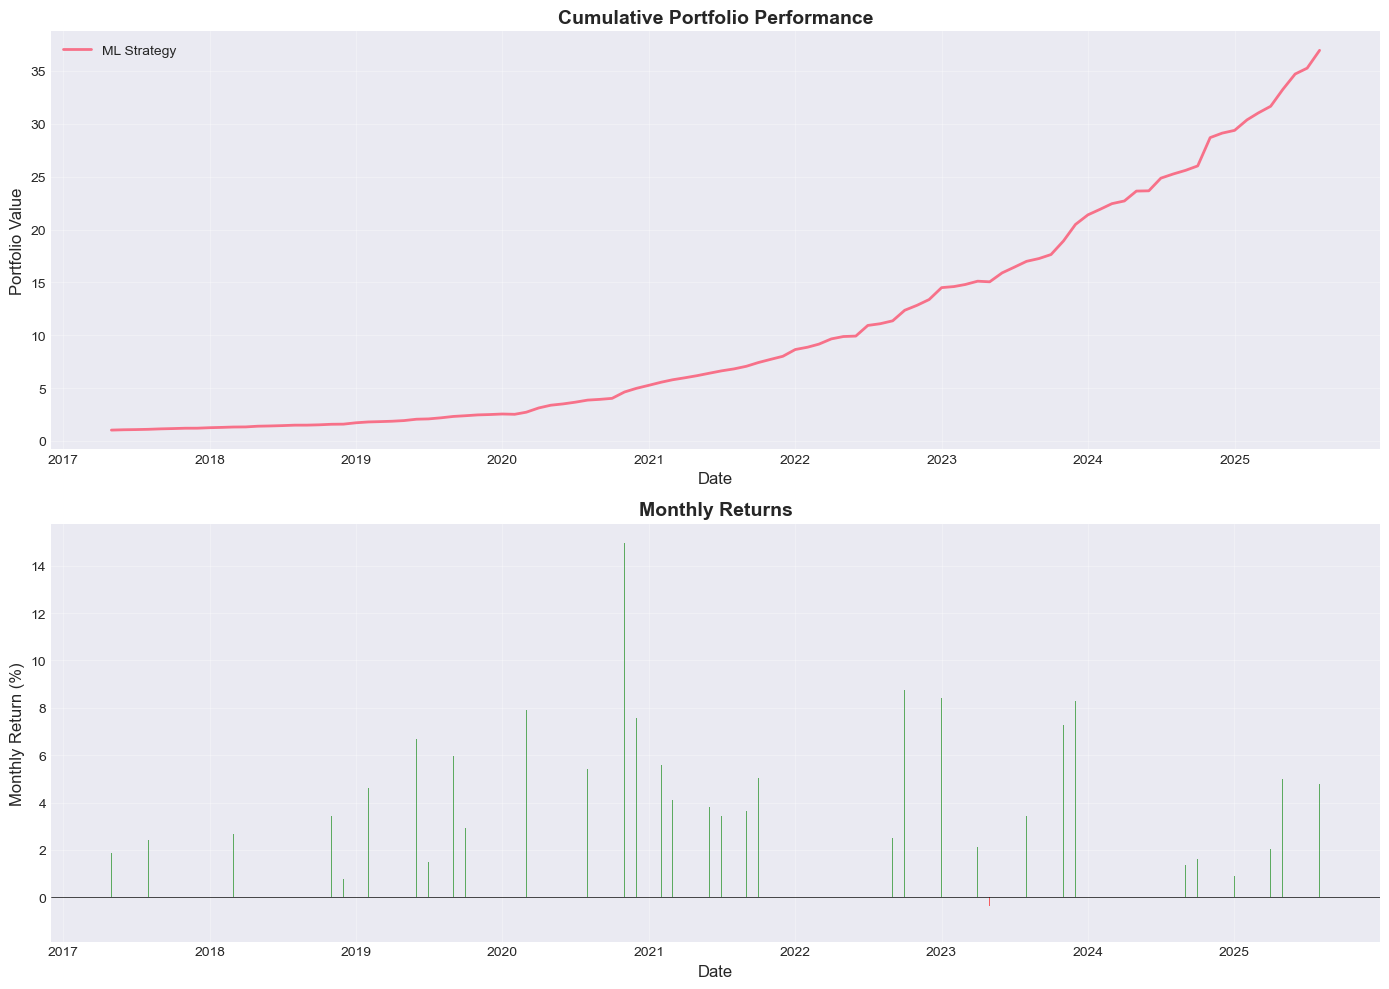

In [16]:
# Portfolio performance plot
perf_fig = plot_portfolio_performance(backtest_results)
plt.show()

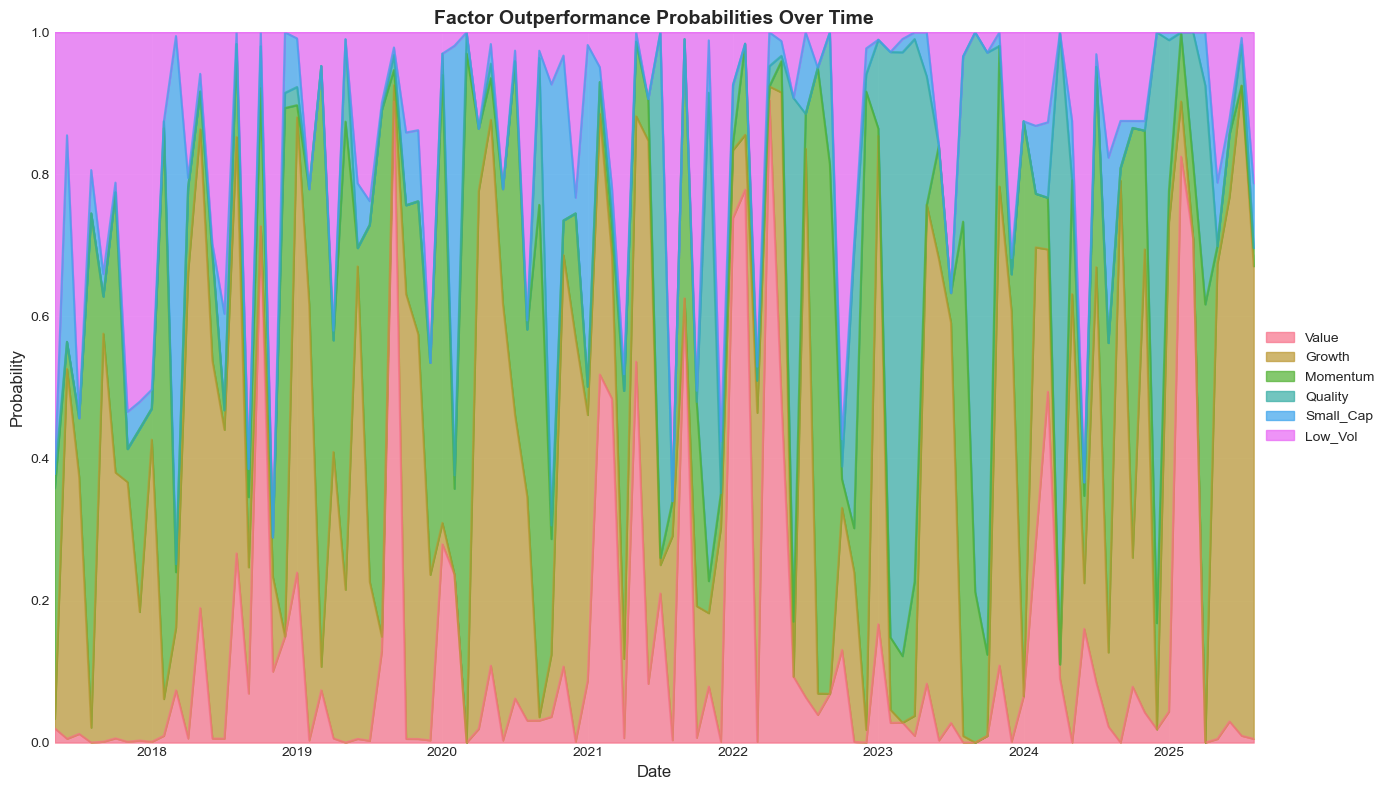

In [17]:
# Factor probabilities over time
results_df = backtest_results['results_df']
test_dates = results_df['Date']
test_weights = results_df[[f'Weight_{f}' for f in factor_cols]]
test_weights.columns = factor_cols
test_weights.index = test_dates

prob_fig = plot_factor_probabilities(test_weights)
plt.show()


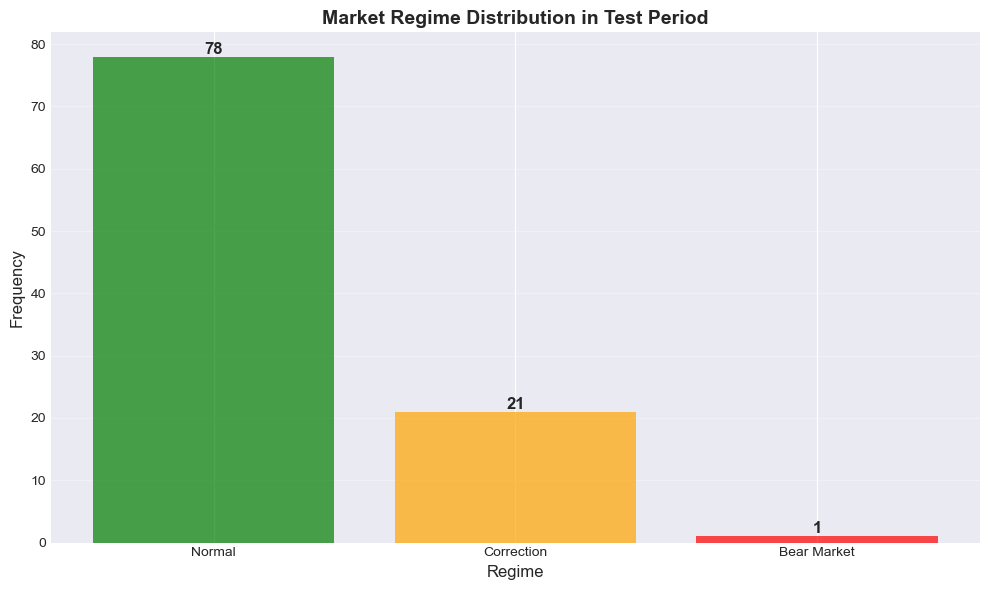

In [18]:
# Regime distribution in test period
regime_counts = results_df['Regime'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green', 'orange', 'red']
labels = ['Normal', 'Correction', 'Bear Market']

bars = ax.bar(regime_counts.index, regime_counts.values, color=colors, alpha=0.7)
ax.set_xlabel('Regime', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Market Regime Distribution in Test Period', fontsize=14, fontweight='bold')
ax.set_xticks(regime_counts.index)
ax.set_xticklabels(labels)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Comparison with Benchmarks

In [19]:
# Calculate equal-weighted benchmark performance
test_start_idx = train_size
test_data = df.iloc[test_start_idx:]

# Equal-weighted strategy
ew_returns = test_data[factor_cols].mean(axis=1)
ew_cumulative = (1 + ew_returns / 100).cumprod()

# ML strategy cumulative returns
ml_cumulative = backtest_results['results_df']['Portfolio_Value']

# Calculate metrics for equal-weighted
ew_metrics = {
    'total_return': (ew_cumulative.iloc[-1] - 1) * 100,
    'annualized_return': (ew_cumulative.iloc[-1]) ** (12 / len(ew_returns)) - 1,
    'annualized_volatility': ew_returns.std() * np.sqrt(12),
    'sharpe_ratio': (ew_returns.mean() * 12) / (ew_returns.std() * np.sqrt(12)),
    'max_drawdown': ((ew_cumulative - ew_cumulative.cummax()) / ew_cumulative.cummax()).min(),
    'win_rate': (ew_returns > 0).sum() / len(ew_returns)
}

# Comparison table
comparison = pd.DataFrame({
    'ML Strategy': [
        f"{metrics['total_return']:.2f}%",
        f"{metrics['annualized_return']*100:.2f}%",
        f"{metrics['annualized_volatility']:.2f}%",
        f"{metrics['sharpe_ratio']:.2f}",
        f"{metrics['max_drawdown']*100:.2f}%",
        f"{metrics['win_rate']*100:.2f}%"
    ],
    'Equal-Weighted': [
        f"{ew_metrics['total_return']:.2f}%",
        f"{ew_metrics['annualized_return']*100:.2f}%",
        f"{ew_metrics['annualized_volatility']:.2f}%",
        f"{ew_metrics['sharpe_ratio']:.2f}",
        f"{ew_metrics['max_drawdown']*100:.2f}%",
        f"{ew_metrics['win_rate']*100:.2f}%"
    ]
}, index=['Total Return', 'Ann. Return', 'Ann. Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate'])

print("\nSTRATEGY COMPARISON")
print(comparison)



STRATEGY COMPARISON
                ML Strategy Equal-Weighted
Total Return       3595.49%         47.91%
Ann. Return          54.21%          4.81%
Ann. Volatility       9.78%          6.71%
Sharpe Ratio           4.56           0.74
Max Drawdown         -1.07%        -12.43%
Win Rate             98.00%         59.00%


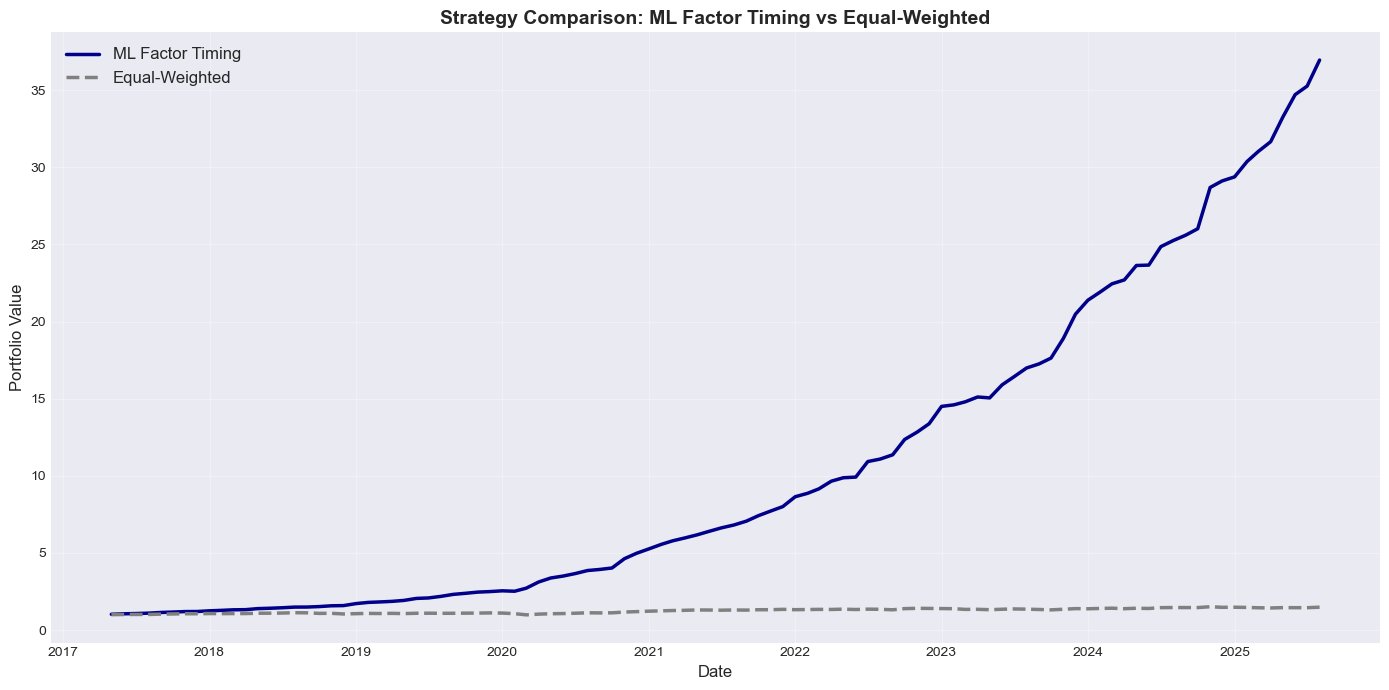

In [20]:
# Plot comparison
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(test_data.index, ml_cumulative.values, 
        linewidth=2.5, label='ML Factor Timing', color='darkblue')
ax.plot(test_data.index, ew_cumulative.values, 
        linewidth=2.5, label='Equal-Weighted', color='gray', linestyle='--')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value', fontsize=12)
ax.set_title('Strategy Comparison: ML Factor Timing vs Equal-Weighted', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Export Results

In [21]:
# Save results to CSV
output_dir = './outputs'
import os
os.makedirs(output_dir, exist_ok=True)

# Save backtest results
results_df.to_csv(f'{output_dir}/backtest_results.csv', index=False)
print(f" Backtest results saved to {output_dir}/backtest_results.csv")

# Save enriched data with regimes and features
df.to_csv(f'{output_dir}/data_with_features.csv')
print(f" Enhanced data saved to {output_dir}/data_with_features.csv")


 Backtest results saved to ./outputs/backtest_results.csv
 Enhanced data saved to ./outputs/data_with_features.csv


## 10. Summary and Conclusions

### Key Findings:

1. **Market Regime Identification**: The model successfully identified distinct market risk regimes based on drawdown patterns

2. **Factor Performance**: Different factors perform better in different regimes, validating the two-stage approach

3. **Strategy Performance**: The ML-based factor timing strategy demonstrated strong risk-adjusted returns compared to equal-weighting

### Methodology Highlights:

- **Stage 1**: K-Means clustering + Stacking Ensemble (RF, SVC, GNB + Logistic Regression)
- **Stage 2**: Regime-specific Random Forest classifiers
- **Features**: Financial turbulence, market drawdown
- **Class Balancing**: SMOTE for handling imbalanced regime distribution

### Future Enhancements:

1. Add macroeconomic features (inflation, GDP growth, financial conditions, policy expectations)
2. Implement transaction costs and realistic trading constraints
3. Explore alternative regime identification methods
4. Test with longer historical data and different factor definitions
5. Add risk management overlays (volatility targeting, stop-losses)
